<a href="https://colab.research.google.com/github/jameswrbrookes/ccbs-sentiment-analysis-tutorial-r/blob/main/ccbs_sentiment_analysis_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Packages

We will use the following packages in this notebook:

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import re
import random
import string
import tensorflow as tf

# Goal

The goal is to build a performant sentiment analysis system, which classifies movie reviews as `positive` or `negative`.

To do that, we will need at the very minimum some training data, some featurization of the data, a model, and an evaluation metric.

# Data and Data Exploration

We will use a sample of [Maas et al. (2011)](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) IMDB dataset.  Their original dataset contains 25,000 labeled training observations, 25,000 labeled test observations, and 50,000 unlabeled observations.  We use a sample of 10,000 labeled training observations, which have themselves been split 60/20/20 into train/dev/test sets. Duplicates have been removed, but the text has otherwise not been preprocessed.

In [ ]:
imdb = pd.read_parquet('/content/drive/MyDrive/imdb-data/imdb-sample.parquet')

In [ ]:
imdb

,text,label,split
0,While the idea is more original than most Sci-...,neg,train
1,I had a lot of expectations from this movie an...,neg,train
2,I had heard some bad things about Cabin Fever ...,neg,train
3,Ohhh man! Now this is what I'm talking about! ...,neg,train
4,You got to go and dig those holes. Holes only ...,pos,train
...,...,...,...
9995,I really felt cheated after seeing this pictur...,neg,test
9996,"Now look, I won't lie to you, but I only got t...",neg,test
9997,The Color Purple is about the struggles of lif...,pos,test
9998,Have you heard the story about the reluctant h...,pos,test


## Check how many observations we have for each split

In [ ]:
imdb['split'].value_counts()

train    6000
dev      2000
test     2000
Name: split, dtype: int64

## Look at the distribution of the labels

In [ ]:
(imdb.groupby('split')['label'].value_counts(normalize = True) * 100).round(1)

split  label
dev    pos      50.8
       neg      49.2
test   neg      50.5
       pos      49.5
train  neg      50.5
       pos      49.5
Name: label, dtype: float64

## Split into separate dataframes

In [ ]:
train_imdb = imdb[imdb.split == 'train'].drop("split", axis = 1)
dev_imdb = imdb[imdb.split == 'dev'].drop("split", axis = 1)
test_imdb = imdb[imdb.split == 'test'].drop("split", axis = 1)

## Look at some interesting attributes of the data

Now we look at some interesting attributes of the data.  But, we will only consider the training data, as the exploratory stage can often give us insight into what kind of features might help our classifiers.

## Look at the text of some examples

In [ ]:
train_imdb[train_imdb['label'] == "pos"]["text"]

4       You got to go and dig those holes. Holes only ...
5       As a huge fan of the original, I avoided this ...
8       The 74th Oscars was a very good one. Whoopi's ...
11      This is a sublime piece of film-making. It flo...
13      "A Thief in the Night" is a film that was gene...
                              ...                        
5989    I really enjoyed the detail that went into the...
5993    Recap: Zandalee is a young woman that feels mo...
5996    I was dragged to this movie about four years a...
5998    I loved this movie. It is a definite inspirati...
5999    Burlinson and Thornton give an outstanding per...
Name: text, Length: 2972, dtype: object

In [ ]:
print("POSITIVE REVIEWS ========================================================\n")
for example in train_imdb[train_imdb['label'] == "pos"]["text"].sample(5, random_state = 123):
  print(example)
  print('\n----------------------------------------------------------------------\n')

print("\n\n\nNEGATIVE REVIEWS ========================================================\n")
for example in train_imdb[train_imdb['label'] == "neg"]["text"].sample(5, random_state = 123):
  print(example)
  print('\n----------------------------------------------------------------------\n')

POSITIVE REVIEWS ========================================================

There are good ways to make a movie and bad ways and this very much the former. This short caper exacts nothing more than what it gives to the audience. It presents a simple story, told very plainly with enough wisecracks to keep you going, then just gets better and better. Clooney's cameo is funny and very welcome but the leads including Sam Rockwell and Luiz Guzman can easily make it on their own. Likeable and funny, hilariously so towards the end, Welcome to Collinwood is a welcome addition to the heist genre.

----------------------------------------------------------------------

Spacecamp is a movie that I plan to show my Daughter Julia Ann Ruth Morgan some day. Seeing Joaquin Phoenix in this movie makes you realize how far hes come since playing a Roman Emperor in the film Gladiator. I am pleased to say that I now have comms with the Artificial Intelligence of QE2 who said that I was Young and that is tru

In [ ]:
markup_ptn = re.compile(r"<[a-z]+ />")

markup_types = []

for example in train_imdb['text']:
  markup_types.extend(markup_ptn.findall(example))


In [ ]:
set(markup_types)

{'<br />'}

So we should probably remove this.

### Length of reviews

In [ ]:
def get_num_words(r):
  return len(str(r).split())

In [ ]:
pos_review_lengths = train_imdb[train_imdb['label'] == 'pos']['text'].apply(get_num_words)
neg_review_lengths = train_imdb[train_imdb['label'] == 'neg']['text'].apply(get_num_words)

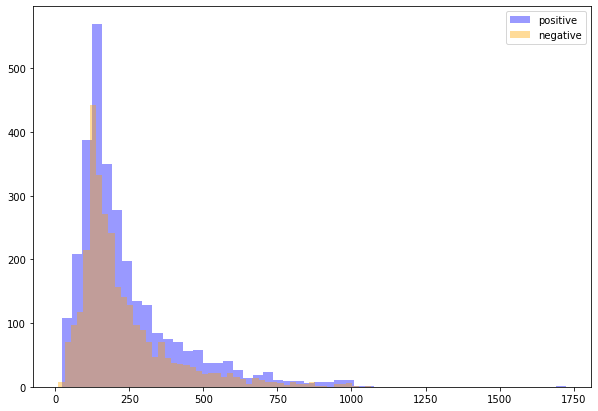

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(pos_review_lengths, bins = 50, alpha = 0.4, color = 'blue')
plt.hist(neg_review_lengths, bins = 50, alpha = 0.4, color = 'orange')
plt.legend(["positive", "negative"])

In [ ]:
print(f"The mean length of positive reviews is {np.mean(pos_review_lengths):.2f} words")
print(f"The mean length of negative reviews is {np.mean(neg_review_lengths):.2f} words")

The mean length of positive reviews is 238.61 words
The mean length of negative reviews is 228.95 words


In [ ]:
print(f"97.5% of positive reviews is {np.quantile(pos_review_lengths, q = .95):.2f} words")
print(f"97.5% of negative reviews is {np.quantile(neg_review_lengths, q = .95):.2f} words")

97.5% of positive reviews is 608.80 words
97.5% of negative reviews is 571.95 words


### Frequency of negation

In [ ]:
def get_negation_rate(r):

  split_r = r.split()
  neg_r = [1 for word in split_r if word.lower() in ["not", "yet", "hardly", "never", "no", "nowhere", "nobody"]]
  reduced_neg_r = re.findall("n't", r.lower())

  return (len(neg_r) + len(reduced_neg_r)) / len(split_r) * 10**6


In [ ]:
pos_review_neg_rate = train_imdb[train_imdb['label'] == 'pos']['text'].apply(get_negation_rate)
neg_review_neg_rate = train_imdb[train_imdb['label'] == 'neg']['text'].apply(get_negation_rate)

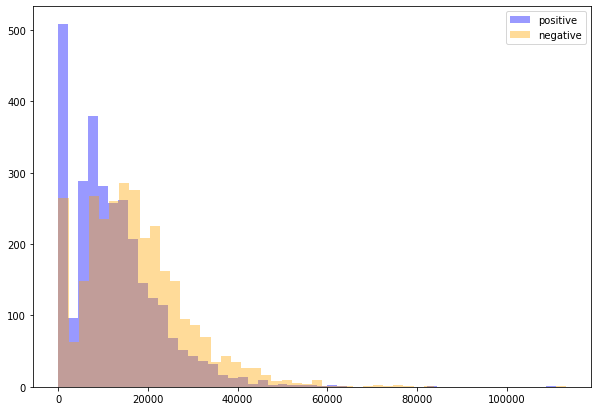

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(pos_review_neg_rate, bins = 50, alpha = 0.4, color = 'blue', label = 'positive')
plt.hist(neg_review_neg_rate, bins = 50, alpha = 0.4, color = 'orange', label = 'negative')
plt.legend(["positive", "negative"])

In [ ]:
print(f"The mean rate of negation in positive reviews is {np.mean(pos_review_neg_rate):.2f} per million words")
print(f"The mean rate of negation in negative reviews is {np.mean(neg_review_neg_rate):.2f} per million words")

The mean rate of negation in positive reviews is 12189.94 per million words
The mean rate of negation in negative reviews is 17187.28 per million words


In [ ]:
re.findall("n't", "do like that one very much and that one is")

[]

### Downtoners

In [ ]:
def num_downtoners(r):

  num_words = len(r.split())
  num_dt = len(re.findall(r'(somewhat|kinda|kind of|sorta|sort of|a bit|a little bit|slighly|only just|ish)\b', r.lower()))

  return num_dt / num_words * 10**6

In [ ]:
pos_review_happy_emoji_rate = train_imdb[train_imdb['label'] == 'pos']['text'].apply(num_downtoners)
neg_review_happy_emoji_rate = train_imdb[train_imdb['label'] == 'neg']['text'].apply(num_downtoners)

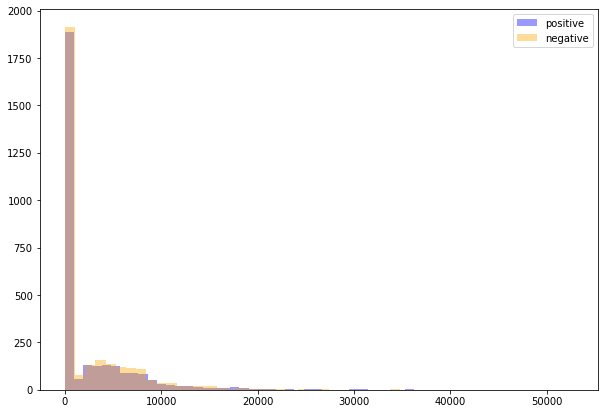

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(pos_review_happy_emoji_rate, bins = 50, alpha = 0.4, color = 'blue', label = 'positive')
plt.hist(neg_review_happy_emoji_rate, bins = 50, alpha = 0.4, color = 'orange', label = 'negative')
plt.legend(["positive", "negative"])

### First person references

In [ ]:
def get_first_person_refs(r):

  split_r = r.split()
  first_r = [1 for word in split_r if word.lower() in ["i", "me", "myself", "mine", "i'm", "i've", "i'd"]]

  return len(first_r) / len(split_r) * 10**6

In [ ]:
pos_review_first_person_rate = train_imdb[train_imdb['label'] == 'pos']['text'].apply(get_first_person_refs)
neg_review_first_person_rate = train_imdb[train_imdb['label'] == 'neg']['text'].apply(get_first_person_refs)

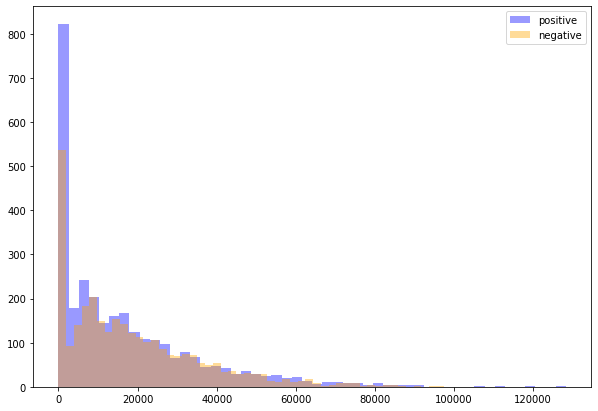

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(pos_review_first_person_rate, bins = 50, alpha = 0.4, color = 'blue', label = 'positive')
plt.hist(neg_review_first_person_rate, bins = 50, alpha = 0.4, color = 'orange', label = 'negative')
plt.legend(["positive", "negative"])

In [ ]:
print(f"The mean rate of 1st person refs in positive reviews is {np.mean(pos_review_first_person_rate):.2f} per million words")
print(f"The mean rate of 1st person refs in negative reviews is {np.mean(neg_review_first_person_rate):.2f} per million words")

The mean rate of 1st person refs in positive reviews is 16501.18 per million words
The mean rate of 1st person refs in negative reviews is 18625.26 per million words


### Words that univariately distinguish the classes

In [ ]:
# extremely simple preprocessing/text cleaning
def clean_review_for_lexicon_approach(r):
  # lower case
  r = r.lower()
  # remove clausal punctuation
  r = re.sub(r"[.,:;()]", "", r)
  return r

In [ ]:
def count_words(data, label, min_count):

  all_words = ' '.join(data[data['label'] == label]['text'].apply(clean_review_for_lexicon_approach)).split()
  word_counts = pd.Series(all_words).value_counts()
  word_counts = word_counts[word_counts >= min_count]
  word_counts = np.log( word_counts / np.sum(word_counts))
  return word_counts


In [ ]:
pos_review_word_counts = count_words(train_imdb, "pos", 25)
neg_review_word_counts = count_words(train_imdb, "neg", 25)

In [ ]:
review_word_counts = pd.concat([pos_review_word_counts, neg_review_word_counts], axis = 1)

In [ ]:
review_word_counts.columns = ['pos', 'neg']

In [ ]:
review_word_counts = review_word_counts.fillna(np.nanmin(review_word_counts.values))

In [ ]:
review_word_counts_llr = review_word_counts['pos'] - review_word_counts['neg']

In [ ]:
review_word_counts_llr

the             0.037742
and             0.182820
a               0.049401
of              0.078450
to             -0.049977
                  ...   
4/10           -0.014908
alas           -0.014908
fool           -0.014908
screams        -0.014908
unbelievably   -0.014908
Length: 2844, dtype: float64

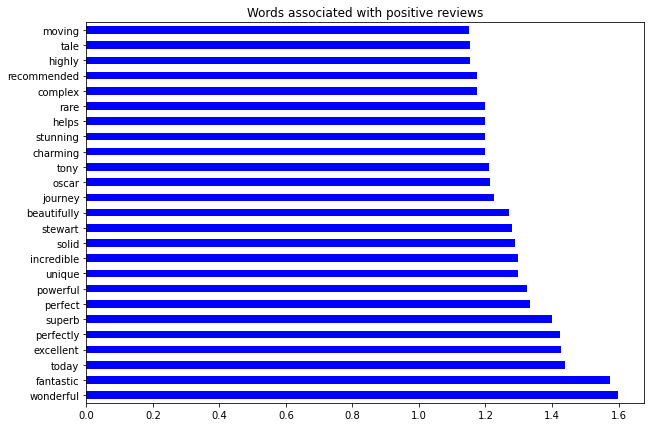

In [ ]:
top_pos_words = review_word_counts_llr.sort_values(ascending = False).head(25)

plt.figure(figsize = (10,7))
top_pos_words.plot(kind = 'barh', color = 'blue')
plt.title('Words associated with positive reviews');

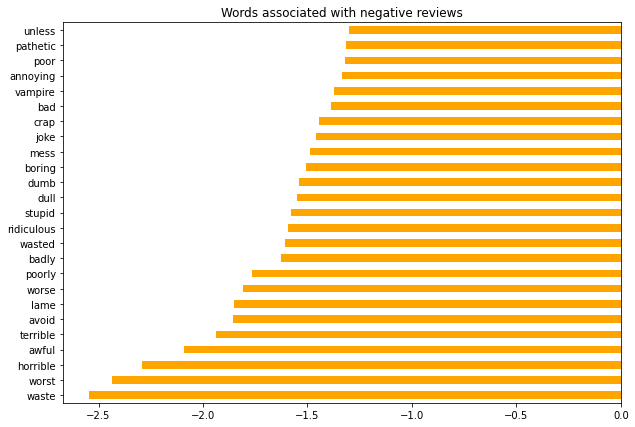

In [ ]:
top_neg_words = review_word_counts_llr.sort_values(ascending = True).head(25)

plt.figure(figsize = (10,7))
top_neg_words.plot(kind = 'barh', color = 'orange')
plt.title('Words associated with negative reviews');

### Others?

There may be other things you want to explore.  The crucial thing here is to look at the linguistics literature on affect, stance, etc.  This can help guide what you might want to look at.

# Evaluation Metric

How are we going to decide whether our system is performant or not?  We will use Macro F1 as that is fairly common in NLP, but you should be aware that other metrics (Brier, AUROC, ...) might be more appropriate for the problem.

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 6.4 MB/s 


In [ ]:
from tensorflow_addons.metrics import F1Score

# Models

## Lexicon Approach

For our lexicon approach, we will use

Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews."
;       Proceedings of the ACM SIGKDD International Conference on Knowledge
;       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle,
;       Washington, USA,

Original Positive words: 2006
Negative words: 4783
Useful properties: includes mis-spellings, morphological variants, slang, and social-media mark-up

See here for others: http://sentiment.christopherpotts.net/lexicons.html#resources

We are using a variant of it, which as P = 2003 and N = 4780, which removes words in the intersection of both.

In [ ]:
liu_lex = pd.read_csv("/content/drive/MyDrive/liu-sentiment-lexicon/liu-sentiment-lexicon.csv")

In [ ]:
# v simple preprocessing/text cleaning -----------------------------------------
def clean_review_for_lexicon_approach(r):

  # convert to string just in case
  r = str(r)

  # lower case
  r_lower = r.lower()

  # remove clausal punctuation
  r_clean = re.sub(r"[.,:;()]", "", r_lower)

  return r_clean

# simple tokenization splitting on whitespace ----------------------------------
def tokenize_review_for_lexicon_approach(r):

  # clean the text with the above function
  r = clean_review_for_lexicon_approach(r)

  # split it on whitespace
  r_split = r.split()

  # convert to a pandas series
  return pd.Series(r_split, name = 'word')


# get the sentiment ------------------------------------------------------------
def get_lexicon_based_sentiment(r):

  # tokenize the review
  tokenized_review = tokenize_review_for_lexicon_approach(r)

  # do a left join
  review_words_with_sentiment = pd.merge(left = tokenized_review, right = liu_lex, how = "left")

  # remove the NaNs
  review_words_with_sentiment = review_words_with_sentiment.dropna()

  # get the score (mean of the sentiment scores)
  score = np.mean(review_words_with_sentiment['sentiment'])

  # get a class

  if bool(score):
    if score > 0:
      return 'pos'
    elif score < 0:
      return 'neg'
    else:
      return random.choice(['pos', 'neg'])
  else:
    return random.choice(['pos', 'neg'])


In [ ]:
lex_model_train_preds = train_imdb['text'].apply(get_lexicon_based_sentiment)
lex_model_train_f1_score = f1_score(train_imdb['label'], lex_model_train_preds, average = 'macro')
print(f"Train F1-score using lexicon approach: {lex_model_train_f1_score:.4f}")

Train F1-score using lexicon approach: 0.7280


In [ ]:
lex_model_dev_preds = dev_imdb['text'].apply(get_lexicon_based_sentiment)
lex_model_dev_f1_score = f1_score(dev_imdb['label'], lex_model_dev_preds, average = 'macro')
print(f"Dev F1-score using lexicon approach: {lex_model_dev_f1_score:.4f}")

Dev F1-score using lexicon approach: 0.7210


## Traditional Machine Learning Approach

We will investigate (and tune) logistic regression on three (sparse) featurizations of the dataset:

i) unigram model

ii) unigram + bigram model

iii) unigram + bigram + hand-built features

### Preprocessing setup



To preprocess the data, we will:
* deal with negation;
* tokenize the text according to a sentiment-aware tokenizer;
* avoid stemming, case-folding, removal of stopwords.

In [ ]:
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer

In [ ]:
potts_tokenizer = TweetTokenizer()
tb_tokenizer = TreebankWordTokenizer()

In [ ]:
potts_tokenizer.tokenize('@mygoodfriend That was good film :)')

['@mygoodfriend', 'That', 'was', 'good', 'film', ':)']

In [ ]:
tb_tokenizer.tokenize('@mygoodfriend That was good film :)')

['@', 'mygoodfriend', 'That', 'was', 'good', 'film', ':', ')']

In [ ]:
negation_list = ['not', 'never', 'no', 'nobody', 'noone', 'nowhere', 'never']

In [ ]:
def preprocess_and_tokenize_document(review):

  # tokenize it according to the TweetTokenizer
  review_tokenized = potts_tokenizer.tokenize(review)
  negated_review_tokenized = []


  negation_in_memory = 0
  for word in review_tokenized:
    if re.search('[.,:;]', word):
      negation_in_memory = 0
      negated_review_tokenized.append(word)
    elif "n't" in word or word in negation_list:
      negation_in_memory = 1
      negated_review_tokenized.append(word)
    else:
      if negation_in_memory == 1:
        negated_review_tokenized.append(word + '_NEG')
      else:
        negated_review_tokenized.append(word)

    # if "n't" in word or word in negation_list:
    #   print(word + "_NEG")

  return negated_review_tokenized

### Unigram Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
unigram_vectorizer = CountVectorizer(
                                     lowercase = False,
                                     preprocessor = None,
                                     tokenizer = preprocess_and_tokenize_document,
                                     ngram_range = (1,1),
                                     min_df = 10,
                                     binary = True)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
unigram_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

unigram_param_grid = {'C' : C_vals}

unigram_gridsearch = GridSearchCV(unigram_lr, unigram_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.pipeline import Pipeline
unigram_pipeline = Pipeline(steps = [
    ("unigram_preprocessor_and_tokenizer", unigram_vectorizer),
    ("unigram_logit_gridsearch", unigram_gridsearch)
])

In [ ]:
unigram_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

Pipeline(steps=[('unigram_preprocessor_and_tokenizer',
                 CountVectorizer(binary=True, lowercase=False, min_df=10,
                                 tokenizer=<function preprocess_and_tokenize_document at 0x7f152abc2320>)),
                ('unigram_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
unigram_lr_train_preds = unigram_pipeline.predict(train_imdb['text'].values)
unigram_lr_train_f1_score = f1_score(train_imdb['label'], unigram_lr_train_preds, average = 'macro')
print(f"Train F1-score using unigrams in logistic regression: {unigram_lr_train_f1_score:.4f}")

Train F1-score using unigrams in logistic regression: 0.9857


In [ ]:
unigram_lr_dev_preds = unigram_pipeline.predict(dev_imdb['text'].values)
unigram_lr_dev_f1_score = f1_score(dev_imdb['label'], unigram_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using unigrams in logistic regression: {unigram_lr_dev_f1_score:.4f}")

Dev F1-score using unigrams in logistic regression: 0.8584


### Bigram Model

In [ ]:
bigram_vectorizer = CountVectorizer(
                                     lowercase = False,
                                     preprocessor = None,
                                     tokenizer = preprocess_and_tokenize_document,
                                     ngram_range = (2,2),
                                     min_df = 10,
                                     binary = True)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
bigram_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

bigram_param_grid = {'C' : C_vals}

bigram_gridsearch = GridSearchCV(bigram_lr, bigram_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.pipeline import Pipeline
bigram_pipeline = Pipeline(steps = [
    ("bigram_preprocessor_and_tokenizer", bigram_vectorizer),
    ("bigram_logit_gridsearch", bigram_gridsearch)
])

In [ ]:
bigram_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

Pipeline(steps=[('bigram_preprocessor_and_tokenizer',
                 CountVectorizer(binary=True, lowercase=False, min_df=10,
                                 ngram_range=(2, 2),
                                 tokenizer=<function preprocess_and_tokenize_document at 0x7f152abc2320>)),
                ('bigram_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
bigram_pipeline

Pipeline(steps=[('bigram_preprocessor_and_tokenizer',
                 CountVectorizer(binary=True, lowercase=False, min_df=10,
                                 ngram_range=(2, 2),
                                 tokenizer=<function preprocess_and_tokenize_document at 0x7f152abc2320>)),
                ('bigram_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
bigram_lr_train_preds = bigram_pipeline.predict(train_imdb['text'].values)
bigram_lr_train_f1_score = f1_score(train_imdb['label'], bigram_lr_train_preds, average = 'macro')
print(f"Train F1-score using unigrams+bigrams in logistic regression: {bigram_lr_train_f1_score:.4f}")

Train F1-score using unigrams+bigrams in logistic regression: 0.9947


In [ ]:
bigram_lr_dev_preds = bigram_pipeline.predict(dev_imdb['text'].values)
bigram_lr_dev_f1_score = f1_score(dev_imdb['label'], bigram_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using unigrams+bigrams in logistic regression: {bigram_lr_dev_f1_score:.4f}")

Dev F1-score using unigrams+bigrams in logistic regression: 0.8295


### Unigram + Bigram Model

In [ ]:
unibigram_vectorizer = CountVectorizer(
                                     lowercase = True,
                                     preprocessor = None,
                                     tokenizer = preprocess_and_tokenize_document,
                                     ngram_range = (1,2),
                                     min_df = 10,
                                     binary = True)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
unibigram_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

unibigram_param_grid = {'C' : C_vals}

unibigram_gridsearch = GridSearchCV(unibigram_lr, unibigram_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.pipeline import Pipeline
unibigram_pipeline = Pipeline(steps = [
    ("unibigram_preprocessor_and_tokenizer", unibigram_vectorizer),
    ("unibigram_logit_gridsearch", unibigram_gridsearch)
])

In [ ]:
unibigram_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

Pipeline(steps=[('unibigram_preprocessor_and_tokenizer',
                 CountVectorizer(binary=True, min_df=10, ngram_range=(1, 2),
                                 tokenizer=<function preprocess_and_tokenize_document at 0x7f152abc2320>)),
                ('unibigram_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
unibigram_pipeline[0]

CountVectorizer(binary=True, min_df=10, ngram_range=(1, 2),
                tokenizer=<function preprocess_and_tokenize_document at 0x7f152abc2320>)

In [ ]:
len(unibigram_pipeline.steps[0][1].get_feature_names_out())

26505

In [ ]:
unibigram_pipeline.steps[1][1].best_estimator_

LogisticRegression(C=0.1, max_iter=10000)

In [ ]:
unibigram_lr_train_preds = unibigram_pipeline.predict(train_imdb['text'].values)
unibigram_lr_train_f1_score = f1_score(train_imdb['label'], unibigram_lr_train_preds, average = 'macro')
print(f"Train F1-score using unigrams+bigrams in logistic regression: {unibigram_lr_train_f1_score:.4f}")

Train F1-score using unigrams+bigrams in logistic regression: 0.9983


In [ ]:
unibigram_lr_dev_preds = unibigram_pipeline.predict(dev_imdb['text'].values)
unibigram_lr_dev_f1_score = f1_score(dev_imdb['label'], unibigram_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using unigrams+bigrams in logistic regression: {unibigram_lr_dev_f1_score:.4f}")

Dev F1-score using unigrams+bigrams in logistic regression: 0.8699


### Hand-build Feature Model

We will investigate 5 features:

- length of the review
- number of words in Liu's positive lexicon, negative lexicon, and their ratio
- number of exclamation marks
- number of words with lengthening
- number of all caps

In [ ]:
def phi_review_length(review):

  # tokenize it according to the TweetTokenizer
  review_tokenized = potts_tokenizer.tokenize(review)

  # get number of words
  return len(review_tokenized)


In [ ]:
def phi_liu_metrics(review):

  # tokenize it according to the TweetTokenizer
  review_tokenized = [w.lower() for w in potts_tokenizer.tokenize(review)]

  # convert into a series
  review_tokenized = pd.Series(review_tokenized, name = "word")

  # merge with the liu dataset
  review_words_with_sentiment = pd.merge(left = review_tokenized, right = liu_lex, how = "left")
  review_words_with_sentiment = review_words_with_sentiment.dropna()

  # class counts
  sentiment_class_counts = review_words_with_sentiment['sentiment'].value_counts()

  # number of positives
  try:
    num_pos = sentiment_class_counts[1] + 1
  except:
    num_pos = 1

  # number of negatives
  try:
    num_neg = sentiment_class_counts[-1] + 1
  except:
    num_neg = 1

  # vocabulary size
  vocab_size = len(set(review_tokenized))

  # augmented review length
  review_len = len(review_tokenized) + vocab_size

  # positive rate
  pos_rate = num_pos / review_len

  # negative rate
  neg_rate = num_neg / review_len

  # their ratio
  pos_neg_ratio = pos_rate / neg_rate


  return num_pos, pos_rate, num_neg, neg_rate, pos_neg_ratio

In [ ]:
def phi_number_of_exclams(review):
  return len(re.findall('!', review))

In [ ]:
def phi_number_of_letter_lenthenings(review):

  review_lower = review.lower()

  letter_lengthenings = []

  for letter in string.ascii_lowercase:
    letter_lengthenings.extend(re.findall(f"{letter}{{4,}}", review_lower))

  return len(letter_lengthenings)

In [ ]:
def phi_vector(review):

  # review length
  rev_len = phi_review_length(review)

  # liu metrics
  num_pos, pos_rate, num_neg, neg_rate, pos_neg_ratio = phi_liu_metrics(review)

  # exclamations
  num_exclams = phi_number_of_exclams(review)

  return rev_len, num_pos, pos_rate, num_neg, neg_rate, pos_neg_ratio, num_exclams



In [ ]:
def phi_matrix(reviews):

  feature_matrix = np.zeros(shape = (len(reviews), len(phi_vector(reviews[0]))))

  for i, review in enumerate(reviews):
    feature_matrix[i,:] = phi_vector(review)

  return feature_matrix

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class PhiFeaturizer(BaseEstimator, TransformerMixin):
    # initializer
    def __init__(self):
        # save the features list internally in the class
        self.phi_feature_names = ["PHI_" + f for f in ["rev_len", "num_pos", \
                                                       "pos_rate", "num_neg", "neg_rate", \
                                                       "pos_neg_ratio", "num_exclams"]]

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        # return the dataframe with the specified features
        return phi_matrix(X)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [ ]:
handcrafted_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

handcrafted_param_grid = {'C' : C_vals}

handcrafted_gridsearch = GridSearchCV(handcrafted_lr, handcrafted_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.pipeline import Pipeline
handcrafted_pipeline = Pipeline(steps = [
    ("handcrafted_featurizer", PhiFeaturizer()),
    ("handcrafted_scaler", MinMaxScaler()),
    ("handcrafted_logit_gridsearch", handcrafted_gridsearch)
])

In [ ]:
handcrafted_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

Pipeline(steps=[('handcrafted_featurizer', PhiFeaturizer()),
                ('handcrafted_scaler', MinMaxScaler()),
                ('handcrafted_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
handcrafted_lr_train_preds = handcrafted_pipeline.predict(train_imdb['text'].values)
handcrafted_lr_train_f1_score = f1_score(train_imdb['label'], handcrafted_lr_train_preds, average = 'macro')
print(f"Train F1-score using headcrafted features in logistic regression: {handcrafted_lr_train_f1_score:.4f}")

Train F1-score using headcrafted features in logistic regression: 0.7333


In [ ]:
handcrafted_lr_dev_preds = handcrafted_pipeline.predict(dev_imdb['text'].values[:50])
handcrafted_lr_dev_f1_score = f1_score(dev_imdb['label'][:50], handcrafted_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using headcrafted features in logistic regression: {handcrafted_lr_dev_f1_score:.4f}")

Dev F1-score using headcrafted features in logistic regression: 0.7182


### Unigram + Bigram + Handbuilt

In [ ]:
from sklearn.pipeline import FeatureUnion

In [ ]:
all_features_preproc =  FeatureUnion([
                                     ("vectorizer", CountVectorizer(
                                                                  lowercase = True,
                                                                  preprocessor = None,
                                                                  tokenizer = preprocess_and_tokenize_document,
                                                                  ngram_range = (1,2),
                                                                  min_df = 10,
                                                                  binary = True)),
                                      ("handcrafted", PhiFeaturizer())
])

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
all_features_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

all_features_param_grid = {'C' : C_vals}

all_features_gridsearch = GridSearchCV(all_features_lr, all_features_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
from sklearn.pipeline import Pipeline
all_features_pipeline = Pipeline(steps = [
    ("all_features_preprocessor_and_tokenizer", all_features_preproc),
    ("scaler", MaxAbsScaler()),
    ("all_features_logit_gridsearch", all_features_gridsearch)
])

In [ ]:
all_features_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

Pipeline(steps=[('all_features_preprocessor_and_tokenizer',
                 FeatureUnion(transformer_list=[('vectorizer',
                                                 CountVectorizer(binary=True,
                                                                 min_df=10,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 tokenizer=<function preprocess_and_tokenize_document at 0x7f152abc2320>)),
                                                ('handcrafted',
                                                 PhiFeaturizer())])),
                ('scaler', MaxAbsScaler()),
                ('all_features_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01

In [ ]:
all_features_lr_train_preds = all_features_pipeline.predict(train_imdb['text'].values)
all_features_lr_train_f1_score = f1_score(train_imdb['label'], all_features_lr_train_preds, average = 'macro')
print(f"Train F1-score using unigrams+bigrams+handcrafted in logistic regression: {all_features_lr_train_f1_score:.4f}")

Train F1-score using unigrams+bigrams+handcrafted in logistic regression: 0.9982


In [ ]:
all_features_lr_dev_preds = all_features_pipeline.predict(dev_imdb['text'].values)
all_features_lr_dev_f1_score = f1_score(dev_imdb['label'], all_features_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using unigrams+bigrams+handcrafted in logistic regression: {all_features_lr_dev_f1_score:.4f}")

Dev F1-score using unigrams+bigrams+handcrafted in logistic regression: 0.8714


### Results on the dev set

In [ ]:
model_names = ['unigram', 'bigram', 'unigram+bigram', 'hand-built', 'all']
data = ['train', 'dev']
results = [ [ unigram_lr_train_f1_score, unigram_lr_dev_f1_score],
            [ bigram_lr_train_f1_score, bigram_lr_dev_f1_score],
            [ unibigram_lr_train_f1_score, unibigram_lr_dev_f1_score],
            [ handcrafted_lr_train_f1_score, handcrafted_lr_dev_f1_score],
            [ all_features_lr_train_f1_score , all_features_lr_dev_f1_score],
          ]
pd.DataFrame(results, index = model_names, columns = data)

,train,dev
unigram,0.985666,0.858422
bigram,0.994666,0.829469
unigram+bigram,0.998333,0.869948
hand-built,0.733321,0.718196
all,0.998167,0.871441


### Model comparison of `unigram_lr_dev_f1_score` and `all_features_lr_dev_f1_score`

Options for comparing models are:
- McNemar's test

In [ ]:
all_features_lr_correct = all_features_lr_dev_preds == dev_imdb['label']
unigram_lr_correct = unigram_lr_dev_preds == dev_imdb['label']

In [ ]:
contingency_tab = pd.crosstab(all_features_lr_correct, unigram_lr_correct)

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

In [ ]:
result = mcnemar(contingency_tab, exact=True)

In [ ]:
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

statistic=63.000, p-value=0.042


### Error Analysis of `all_features_lr_dev_f1_score`

In [ ]:
for label in ['pos', 'neg']:
  for text, _ in dev_imdb[(~all_features_lr_correct) & (dev_imdb['label'] == label)].sample(5, random_state = 12).itertuples(index = False):
    print(f"LABEL: {label}")
    print(text)
    print('------------------------------------------------------\n')

LABEL: pos
The 1967 In Cold Blood was perhaps more like "the real thing" (Think about it: would we really want to see the real thing?), but it was black and white in a color world, and a lot of people didn't even know what it was, and there was an opportunity to remake it for television. Plus, if you remake it, you can show some stuff not shown in the original. The book In Cold Blood by Truman Capote was the first "nonfiction novel". Truman's book was in fact not 100% true to the real story. I thought the Canadian location sufficed for Kansas pretty much for a TV movie. Look for the elements of sex, drugs and rock 'n' roll: Dick's womanizing, Perry being an aspirin junkie, Perry playing blues guitar.
------------------------------------------------------

LABEL: pos
"The Ladies Man" suffers a common problem among movies based on "Saturday Night Live" skits. And that is, a sketch that usually succeeds in five minutes will not do so well in ninety minutes. Although this movie does have i

,text,label
6001,"Except for the acting of Meryl Streep, which i...",neg
6015,When HEY ARNOLD! first came on the air in 1996...,neg
6022,"Think ""stage play"". This is worth seeing once ...",neg
6023,"Just as ""ITS A MAD, MAD, MAD, MAD WORLD"" is at...",neg
6030,This story about three women is a very sensiti...,neg
...,...,...
7939,"Lois Weber, self proclaimed missionary via the...",neg
7941,"How cynical are the writers, to pander so. I m...",neg
7957,I remember going to see the movie in the summe...,neg
7980,"I dont know about you, but I've always felt dr...",neg


## Deep Learning Approach

### FFNN

In [ ]:
# model constants
max_features = 25000
embedding_dim = 128

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
def custom_standardizer(text):
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '<br />', ' ')
  text = tf.strings.regex_replace(text,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
  return text

In [ ]:
vectorize_layer = TextVectorization(standardize = custom_standardizer,
                                    max_tokens=max_features,
                                    output_mode='int',
                                    output_sequence_length=600)

In [ ]:
vectorize_layer.adapt(train_imdb['text'].values)

In [ ]:
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it']

In [ ]:
len(vectorize_layer.get_vocabulary())

25000

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dropout, GlobalMaxPooling1D, Dense

# A text input.
text_input = Input(shape=(1,), dtype=tf.string, name='text')

# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, max_len) containing vocab indices.
x = vectorize_layer(text_input)

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'. Note that we're using max_features+1 here, since there's an
# OOV token that gets added to the vocabulary in vectorize_layer.
x = Embedding(max_features + 1, embedding_dim)(x)

# global max pooling
x = GlobalMaxPooling1D()(x)

# dropout
x = Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(text_input, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_18 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_57 (Embedding)    (None, 600, 128)          3200128   
                                                                 
 global_max_pooling1d_24 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_57 (Dropout)        (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 1)                 129

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy',
                           restore_best_weights=False,
                           patience = 5)

In [ ]:
batch_size = 32
epochs = 50

# Fit the model using the train and test datasets.
model.fit(x = tf.constant(train_imdb['text'].values, dtype = tf.string),
          y = tf.constant(train_imdb['label'].values == 'pos', dtype = tf.int32),
          validation_data = (tf.constant(dev_imdb['text'].values, dtype = tf.string),
                             tf.constant(dev_imdb['label'].values == 'pos', dtype = tf.int32)),
          epochs=epochs,
          callbacks = [early_stop])

Epoch 1/50
188/188 [==============================] - 2s 8ms/step - loss: 0.6803 - accuracy: 0.5938 - val_loss: 0.6558 - val_accuracy: 0.8020
Epoch 2/50
188/188 [==============================] - 1s 7ms/step - loss: 0.5993 - accuracy: 0.7863 - val_loss: 0.5463 - val_accuracy: 0.8445
Epoch 3/50
188/188 [==============================] - 1s 7ms/step - loss: 0.4763 - accuracy: 0.8363 - val_loss: 0.4467 - val_accuracy: 0.8480
Epoch 4/50
188/188 [==============================] - 1s 7ms/step - loss: 0.3914 - accuracy: 0.8585 - val_loss: 0.3914 - val_accuracy: 0.8565
Epoch 5/50
188/188 [==============================] - 1s 7ms/step - loss: 0.3236 - accuracy: 0.8858 - val_loss: 0.3583 - val_accuracy: 0.8615
Epoch 6/50
188/188 [==============================] - 1s 7ms/step - loss: 0.2845 - accuracy: 0.8992 - val_loss: 0.3375 - val_accuracy: 0.8660
Epoch 7/50
188/188 [==============================] - 1s 7ms/step - loss: 0.2450 - accuracy: 0.9177 - val_loss: 0.3238 - val_accuracy: 0.8685
Epoch 

### CNN

In [ ]:
# model constants
max_features = 25000
embedding_dim = 128

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
def custom_standardizer(text):
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '<br />', ' ')
  text = tf.strings.regex_replace(text,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
  return text

In [ ]:
vectorize_layer = TextVectorization(standardize = custom_standardizer,
                                    max_tokens=max_features,
                                    output_mode='int',
                                    output_sequence_length=600)

In [ ]:
vectorize_layer.adapt(train_imdb['text'].values)

In [ ]:
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it']

In [ ]:
len(vectorize_layer.get_vocabulary())

25000

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dropout, GlobalMaxPooling1D, Conv1D, Dense

# A text input.
text_input = Input(shape=(1,), dtype=tf.string, name='text')

# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, max_len) containing vocab indices.
x = vectorize_layer(text_input)

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'. Note that we're using max_features+1 here, since there's an
# OOV token that gets added to the vocabulary in vectorize_layer.
x = Embedding(max_features + 1, embedding_dim)(x)

# convolutional lauyer
x = Conv1D(128, 4, padding='same', activation='relu', strides=1)(x)

# global max pooling
x = GlobalMaxPooling1D()(x)

# dropout
x = Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(text_input, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_20 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_67 (Embedding)    (None, 600, 128)          3200128   
                                                                 
 conv1d_9 (Conv1D)           (None, 600, 128)          65664     
                                                                 
 global_max_pooling1d_34 (Gl  (None, 128)              0         
 obalMaxPooling1D)                                               
                                                                 
 dropout_67 (Dropout)        (None, 128)               0  

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy',
                           restore_best_weights=False,
                           patience = 5)

In [ ]:
batch_size = 32
epochs = 50

# Fit the model using the train and test datasets.
model.fit(x = tf.constant(train_imdb['text'].values, dtype = tf.string),
          y = tf.constant(train_imdb['label'].values == 'pos', dtype = tf.int32),
          validation_data = (tf.constant(dev_imdb['text'].values, dtype = tf.string),
                             tf.constant(dev_imdb['label'].values == 'pos', dtype = tf.int32)),
          epochs=epochs,
          callbacks = [early_stop])

Epoch 1/50
188/188 [==============================] - 2s 9ms/step - loss: 0.6286 - accuracy: 0.6405 - val_loss: 0.4920 - val_accuracy: 0.7845
Epoch 2/50
188/188 [==============================] - 1s 8ms/step - loss: 0.4258 - accuracy: 0.8100 - val_loss: 0.3845 - val_accuracy: 0.8360
Epoch 3/50
188/188 [==============================] - 1s 8ms/step - loss: 0.2738 - accuracy: 0.8947 - val_loss: 0.3374 - val_accuracy: 0.8500
Epoch 4/50
188/188 [==============================] - 1s 8ms/step - loss: 0.1523 - accuracy: 0.9527 - val_loss: 0.3360 - val_accuracy: 0.8540
Epoch 5/50
188/188 [==============================] - 1s 8ms/step - loss: 0.0683 - accuracy: 0.9825 - val_loss: 0.3855 - val_accuracy: 0.8460
Epoch 6/50
188/188 [==============================] - 1s 8ms/step - loss: 0.0294 - accuracy: 0.9960 - val_loss: 0.4295 - val_accuracy: 0.8390
Epoch 7/50
188/188 [==============================] - 1s 8ms/step - loss: 0.0148 - accuracy: 0.9987 - val_loss: 0.4676 - val_accuracy: 0.8405
Epoch 

### LSTM

In [ ]:
# model constants
max_features = 25000
embedding_dim = 128

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
def custom_standardizer(text):
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '<br />', ' ')
  text = tf.strings.regex_replace(text,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')
  return text

In [ ]:
vectorize_layer = TextVectorization(standardize = custom_standardizer,
                                    max_tokens=max_features,
                                    output_mode='int',
                                    output_sequence_length=600)

In [ ]:
vectorize_layer.adapt(train_imdb['text'].values)

In [ ]:
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'a', 'and', 'of', 'to', 'is', 'in', 'it']

In [ ]:
len(vectorize_layer.get_vocabulary())

25000

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dropout, GlobalMaxPooling1D, Dense, GRU

# A text input.
text_input = Input(shape=(1,), dtype=tf.string, name='text')

# The first layer in our model is the vectorization layer. After this layer,
# we have a tensor of shape (batch_size, max_len) containing vocab indices.
x = vectorize_layer(text_input)

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'. Note that we're using max_features+1 here, since there's an
# OOV token that gets added to the vocabulary in vectorize_layer.
x = Embedding(max_features + 1, embedding_dim)(x)

# BiLSTM
x = Bidirectional(LSTM(128))(x)

# dropout
x = Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
predictions = Dense(1, activation='sigmoid', name='predictions')(x)

model = Model(text_input, predictions)

# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(
    loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text (InputLayer)           [(None, 1)]               0         
                                                                 
 text_vectorization_21 (Text  (None, 600)              0         
 Vectorization)                                                  
                                                                 
 embedding_68 (Embedding)    (None, 600, 128)          3200128   
                                                                 
 bidirectional_49 (Bidirecti  (None, 256)              263168    
 onal)                                                           
                                                                 
 dropout_68 (Dropout)        (None, 256)               0         
                                                                 
 predictions (Dense)         (None, 1)                 257

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy',
                           restore_best_weights=False,
                           patience = 5)

In [ ]:
batch_size = 32
epochs = 50

# Fit the model using the train and test datasets.
model.fit(x = tf.constant(train_imdb['text'].values, dtype = tf.string),
          y = tf.constant(train_imdb['label'].values == 'pos', dtype = tf.int32),
          validation_data = (tf.constant(dev_imdb['text'].values, dtype = tf.string),
                             tf.constant(dev_imdb['label'].values == 'pos', dtype = tf.int32)),
          epochs=epochs,
          callbacks = [early_stop])

Epoch 1/50
188/188 [==============================] - 18s 78ms/step - loss: 0.6482 - accuracy: 0.6092 - val_loss: 0.4982 - val_accuracy: 0.7695
Epoch 2/50
188/188 [==============================] - 14s 74ms/step - loss: 0.4479 - accuracy: 0.8180 - val_loss: 0.5281 - val_accuracy: 0.7690
Epoch 3/50
188/188 [==============================] - 14s 73ms/step - loss: 0.2347 - accuracy: 0.9123 - val_loss: 0.5895 - val_accuracy: 0.7780
Epoch 4/50
188/188 [==============================] - 14s 74ms/step - loss: 0.1128 - accuracy: 0.9655 - val_loss: 0.9575 - val_accuracy: 0.7895
Epoch 5/50
188/188 [==============================] - 14s 74ms/step - loss: 0.0882 - accuracy: 0.9738 - val_loss: 0.6587 - val_accuracy: 0.7940
Epoch 6/50
188/188 [==============================] - 14s 73ms/step - loss: 0.0479 - accuracy: 0.9875 - val_loss: 0.7524 - val_accuracy: 0.7890
Epoch 7/50
188/188 [==============================] - 14s 74ms/step - loss: 0.0444 - accuracy: 0.9880 - val_loss: 0.8710 - val_accuracy: